# Homework 2

Do the programing part of Homework 2 in this notebook. Predefined are function *stubs*. That is, the name of the function and a basic body is predefined. You need to modify the code to fulfil the requirements of the homework.

In [3]:
# import numpy, scipy.optimize and matplotlib
import numpy as np
from scipy import optimize
import matplotlib.pylab as plt

# If you're using Firefox, remove one or both # on the commands below.
# note these `%`-commands are not actually Python commands. They are Jupyter-notebook-specific commands.
#%matplotlib notebook
#%matplotlib notebook

## 1. Lecture Example

In [2]:

# Linear Programming minimizes by default, so we need to add a - to the vector c
c = [-400,-200,-250]
A = [[3,1,1.5],[0.8, 0.2, 0.3],[1,1,1]]
b = [1000,300,625]

sol = optimize.linprog(c, A, b)

In [3]:
print("The optimum solution is:\n  * Corn: ",sol.x[0]," acres\n  * Wheat: ",sol.x[1]," acres\n  * Oats: ",sol.x[2]," acres")
print("The yield is $", -sol.fun)

The optimum solution is:
  * Corn:  41.666666666666664  acres
  * Wheat:  0.0  acres
  * Oats:  583.3333333333334  acres
The yield is $ 162500.0


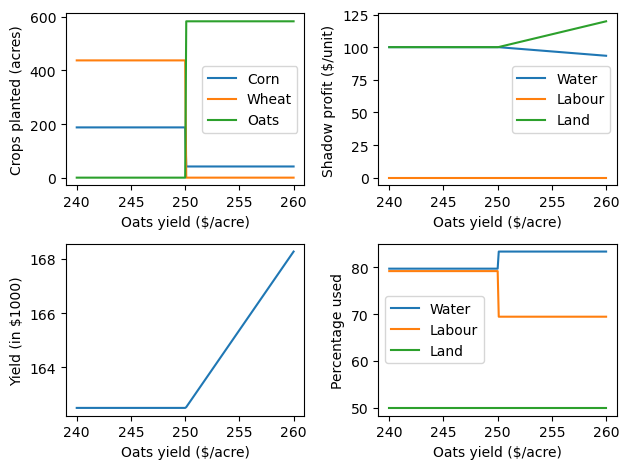

In [8]:

# Let us study what happens for different prices of Oats from $240 to $260

# Linear Programming minimizes by default, so we need to add a - to the vector c
c = lambda x: [-400,-200,-x]
A = [[3,1,1.5],[0.8, 0.2, 0.3],[1,1,1]]
b = [1000,300,625]

oatsmin=240
oatsmax=260
N = 201
delta = (oatsmax-oatsmin)/N

corn = np.zeros(N)
wheat = np.zeros(N)
oats = np.zeros(N)
t_yield = np.zeros(N)
water = np.zeros(N)
labour = np.zeros(N)
land = np.zeros(N)

water_used = np.zeros(N)
labour_used = np.zeros(N)
land_used = np.zeros(N)

for i in range(N):
    oats_p = oatsmin+delta*i

    sol = optimize.linprog(c(oats_p), A, b)

    corn[i] = sol.x[0]
    wheat[i] = sol.x[1]
    oats[i] = sol.x[2]

    t_yield[i] = -sol.fun/1000

    water[i] = -sol.ineqlin.marginals[0]
    labour[i] = -sol.ineqlin.marginals[1]
    land[i] = -sol.ineqlin.marginals[2]

    water_used[i] = 100*(1*corn[i]+0.3*wheat[i]+0.5*oats[i])/400
    labour_used[i] = 100*(1.6*corn[i]+0.4*wheat[i]+0.6*oats[i])/600
    land_used[i] = 100*(corn[i]+wheat[i]+oats[i])/1250

wheat_x = np.linspace(oatsmin, oatsmax, N)


figure, axis = plt.subplots(2,2)


axis[0,0].plot(wheat_x, corn, wheat_x, wheat, wheat_x, oats)
axis[0,0].set_ylabel("Crops planted (acres)")
axis[0,0].set_xlabel("Oats yield ($/acre)")
axis[0,0].legend(["Corn","Wheat","Oats"])


axis[1,0].plot(wheat_x, t_yield)
axis[1,0].set_ylabel("Yield (in $1000)")
axis[1,0].set_xlabel("Oats yield ($/acre)")


axis[0,1].plot(wheat_x, water, wheat_x, labour, wheat_x, land)
axis[0,1].set_ylabel("Shadow profit ($/unit)")
axis[0,1].set_xlabel("Oats yield ($/acre)")
axis[0,1].legend(["Water","Labour","Land"])

# TODO: Add here a 4th subplot using axis[1,1]

axis[1,1].plot(wheat_x, water_used, wheat_x, labour_used, wheat_x, land_used)
axis[1,1].set_ylabel("Percentage used")
axis[1,1].set_xlabel("Oats yield ($/acre)")
axis[1,1].legend(["Water","Labour","Land"])

# End TODO

plt.tight_layout()

plt.show()


## 2. Holland Marsh

In [9]:
import pandas as pd   # library to open excel files

# parameters
G = 3.3  # acre-ft per acre - grass standard
B = 2500  # person-hours/week - total available labor
L = 7200  # acre - total available agricultural land
M = 12000  # machine-hours/week - total available machinery
R = 18.5  # acre-ft per acre - rainfall
I = R * L  # acre-ft - total available water of irrigation
F = 5000  # acre-ft - total available fertilizer
W = 28  # weeks in a season
Cl = 10  # $/(person-hours) - cost of labor
Cm = 15  # $/(person-hours) - cost of machinery
Cf = 5  # $/(acre-ft) - cost of fertilizer

# load the crop data
# the file can be found here https://raw.githubusercontent.com/siefkenj/ IBLODEs/main/dist/odes.pdf
try:
    data = pd.read_excel('crops_data.xlsx', header=None);  # Handle potential missing header
    crops = data.iloc[1:, 0].values.tolist()
    headers = data.iloc[0, 1:].values.tolist()
    data = data.iloc[1:, 1:].values.astype(float) # convert data to numeric type

except FileNotFoundError:
    print("Error: crops_data.xlsx not found. Please ensure the file exists in the correct directory.")
    exit()
except Exception as e: # Catch other potential errors like incorrect file format
    print(f"An error occurred while reading the Excel file: {e}")
    exit()


irrigation = (data[:, 0] + 1) * G
labor = data[:, 1]
machinery = data[:, 2]
fertilizer = data[:, 3]
plantingcosts = data[:, 4]
yield_data = data[:, 5] # Renamed 'yield' to avoid conflict with Python keyword
numcrops = data.shape[0]
constraintlabels = ['labor', 'land', 'machinery', 'irrigation', 'fertilizer'] # be sure to use this order in the rows of A and b below
numconstraints = 5

# setup the linear program
b = np.array([B, L, M, I, F])
A = np.array([labor, np.ones(numcrops), machinery, irrigation, fertilizer])
c = plantingcosts-yield_data    # Minimize planting costs - yield
lb = np.zeros(numcrops)         # lower limit of plot sizes
ub = np.inf * np.ones(numcrops) # upper limit of plot sizes

# solve the linear program
result = optimize.linprog(c, A, b, bounds=list(zip(lb, ub)))
    # zip(lb, ub) makes an array with elements (lb[0], ub[0]), (lb[1], ub[1]), ...

x = result.x
profit = -result.fun
exitflag = result.status  # Check the exit status for successful optimization
lambdacur = result.ineqlin.marginals


# output
tol = 0.01  # don't report the tiny crops
ind = np.arange(numcrops)
print('\noptimal crops:')
ii = ind[x > tol]
si = np.argsort(x[ii])[::-1] # Sort in descending order
ii = ii[si]

for i in ii:
    print(f"  {crops[i]} {round(x[i])} acres")

print('\nprofit: $', round(profit),'\n')

res = b - A @ x    # @ is matrix multiplication
print('binding constraints:', end='')
for i in range(numconstraints):
    if res[i] < 1e-3:
        print(f" {constraintlabels[i]}", end='')
print('\n')


optimal crops:
  alfalfa 3971 acres
  timothy 1714 acres
  green beans 1143 acres
  cauliflower 371 acres

profit: $ 35950086 

binding constraints: labor land machinery fertilizer



## 3 Dimensional Analysis

You can use the script below to help you calculate a basis of the null space of the dimensional matrix.

In [87]:
from numpy.linalg import matrix_rank
from sympy import Matrix, nsimplify, shape

D = Matrix(
        # Add the dimensional matrix here
            [[0,1,1,0],
             [1,0,-1,1],
             [-2,0,0,-1]]
)


print("\nRank(D)=",D.rank())

D_dim = shape(D)[1]
null_dim = D_dim-D.rank()

print("Null space of D has dimension ",null_dim)

v = [] 

print("\nNull Space Basis for D is ")

for i in range(null_dim):
    v.append(np.array(D.nullspace()[i]))
    print('\n',v[i])


Rank(D)= 3
Null space of D has dimension  1

Null Space Basis for D is 

 [[-1/2]
 [-1/2]
 [1/2]
 [1]]
